In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import re
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import xgboost
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#Importing the train data that will be used to create a model
train=pd.read_csv("./Corona_NLP_train.csv",encoding='latin1')
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
#Drop will drop all the columns that aren't needed for the program to train the classifier.
#The resulting table includes the original tweet and its corresponding class. Since there are more than two
#classes, the model will use the multinomial naive bayes classification.
def drop(p):
    p.drop(["UserName","ScreenName","Location","TweetAt"],axis=1,inplace=True)

drop(train)

train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
#Value counts are used to calculate the prior probabilities for each of the classes. This is the denominator value
#for the formula.
train["Sentiment"].value_counts()

#Function maps and replaces the sentiment to a value 0 - 4.
def rep(t):
        d={"Sentiment":{'Positive':0,'Negative':1,"Neutral":2,"Extremely Positive":3,"Extremely Negative":4}}
        t.replace(d,inplace=True)

rep(train)

train

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",4
...,...,...
41152,Airline pilots offering to stock supermarket s...,2
41153,Response to complaint not provided citing COVI...,4
41154,You know itÂs getting tough when @KameronWild...,0
41155,Is it wrong that the smell of hand sanitizer i...,2


In [5]:
#Preparing data: Preprocessing

#Tokenizer to split each original tweet into a list of words. TweetTokenizer is used for tokenizing tweets and
# also removes user handles since a user's name should not be associated with one of the classes.
tweettoken = TweetTokenizer(strip_handles=True, reduce_len=True)

In [6]:
#Instantiates Lemmatizer; reduces a word to its base form
lemmatizer=WordNetLemmatizer()

In [7]:
#Instantiates porter stemmer, reduces word to its stemmed form..
stemmer=PorterStemmer()

In [8]:
collect=[] #Stores preprocessed text
def preprocess(t):
    tee=re.sub('[^a-zA-Z]'," ",t) #Regex to replace all non alphabetic characters with spaces
    tee=tee.lower() #Convert text to lowercase
    res=tweettoken.tokenize(tee) #Splits the text into a list of words
    for i in res:
        if i in stopwords.words('english'): #stop words are removed because they contain no real information on
            res.remove(i)   #the classification of a text
    rest=[]
    #The words are then put into their base form. It would be more efficient to have more words in their base
    # form as it allows the algorithm to classify the word into one class more accurately. The lemmatized form
    # is then concatenated back into a sentence and added to the list
    for k in res: 
        rest.append(lemmatizer.lemmatize(k))
    ret=" ".join(rest)
    collect.append(ret)

In [9]:
#Iterates over each tweet and performs text preprocessing.
for j in range(41157):
    preprocess(train["OriginalTweet"].iloc[j])

In [10]:
# The results of tokenization and text preprocessing.
collect[0]

'menyrbie phil gahan chrisitv http co ifz fan pa http co xx ghgfzcc http co nlzdxno'

In [11]:
#Gather a frequency count of the 200 most popular words
def bow(ll):
    cv=CountVectorizer(max_features=200)
    x=cv.fit_transform(ll).toarray()
    return x

In [12]:
# y = Bag of words representation of the data. Words are counted on their frequency to help put them in a class.
y=bow(collect)

In [13]:
(y[:1])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [14]:
len(y[0][:])

200

In [15]:
#TF-IDF stands for Term Frequency - Inverse Document Frequency and basically works by counting the frequency of 
#a word to measure its importance or weight. The more a frequent a word appears in the document, the more likely
#it is to fit in that class. The IDF is used to minimize the weight of common words that don't add meaning to the
#classification of the text.
def tfidf(xx):
    cv=TfidfVectorizer(max_features=4000)
    x=cv.fit_transform(xx).toarray()
    return x

In [16]:
# Class counts to an array
values=train["Sentiment"].values

values

array([2, 0, 0, ..., 0, 2, 1])

In [17]:
#Splits the data into a train set and a test set. The train set will be used to train the model
#And the test set will be used to calculate the model classifier's performance.
#75% of the data will be used to train and the random state is used to reproduce the same results.
(x_train,x_test,y_train,y_test) = train_test_split(y,values, train_size=0.75, random_state=42)

x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

    x_test: It represents the data that the machine learning model will use to evaluate its performance.
    y_test: These are the actual outcomes or labels against which the model's predictions will be compared during evaluation.

In [18]:
#Skip Random Forest Classifier
rnd_clf=RandomForestClassifier(n_estimators=200,random_state=42)

rnd_clf.fit(x_train,y_train)

rnd_clf.score(x_test,y_test)

y_pred=rnd_clf.predict(x_test)
cm=confusion_matrix(y_test,y_pred)
cm

a=[400,500,600,700,800,900,1000]
for i in a:
    rnd_clf=RandomForestClassifier(n_estimators=i,random_state=42)
    rnd_clf.fit(x_train,y_train)
    t=rnd_clf.score(x_test,y_test)
    print(t)

0.41477162293488823
0.41438289601554906
0.41370262390670554
0.41438289601554906
0.4164237123420797
0.4184645286686103
0.41895043731778425


In [19]:
#Trains the model with the training data. 
#x_train: The data that the model will use to learn patterns and make predictions.
#y_train: The expected labels that the model will try to predict.
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train,y_train)

MultinomialNB()

In [20]:
# Add commands to output confusion matrix for block #34 and for #87.
#Explain in detail what output does the *.score() function provide.

#Evaluates the performance of the trained classifier on the testing data. 
#x_test represents the feature matrix for the testing data, and y_test represents the corresponding target 
#values or labels. The score function calculates the accuracy of the classifier's predictions on the 
#testing data and returns the accuracy score.
#This score provides a measure of how well the classifier is performing on unseen data.
#Higher accuracy indicates better performance.
clf.score(x_test,y_test)

0.3825072886297376

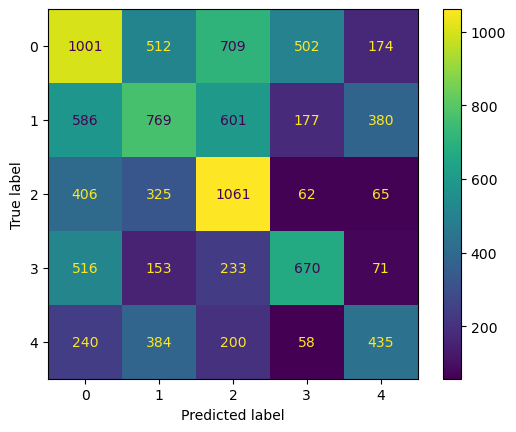

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred = clf.predict(x_test)
matrix1 = confusion_matrix(y_test, pred,labels=clf.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=matrix1,display_labels=clf.classes_)
disp1.plot()

In [22]:
#y= Term Freq - Inverse Doc Freq. Words that appear in all classes have less weight than words that
#are uniquely associated with a certain class.
y=tfidf(collect)
#Splitting the data into train and test again
(x_train,x_test,y_train,y_test) = train_test_split(y,values, train_size=0.75, random_state=42)

In [23]:
#SKIP Random Forest Classifier
rnd_clf=RandomForestClassifier(n_estimators=200,max_leaf_nodes=8,random_state=42)
rnd_clf.fit(x_train,y_train)
rnd_clf.score(x_test,y_test)

0.2937803692905734

In [24]:
#Add commands to output confusion matrix for block #34 and for #87.
#Explain in detail what output does the *.score() function provide.
#Same as before, however a different model was trained with the tfidf function and appears to have become better
#at classifying the test data as the score has increased.
clf = MultinomialNB()
clf.fit(x_train,y_train)
clf.score(x_test,y_test)

0.46763848396501456

In [25]:
#Explain why the score value from block #87 is higher than that from #34. 
#Use the outputs from the two confusion matrices for this analysis. 
#Include the above two explanations as comments at the end of the notebook/program.

#I believe that initial score was lower due to how the model was trained. The initial method used the 
# bag of words algorithm which gave equal weighting to all words. And so it was mostly classifying them based on
#how often this word appeared in a class. This is less effective because the classes are unevenly distributed, and
#therefore the classification model will just put them in the class that it was trained the most with.
#The tdidf algorithm was better for classification because it assigned greater weight to words that are unique
#to a specific class. Also the was given more features which allowed for greater accuracy

Matrix 2


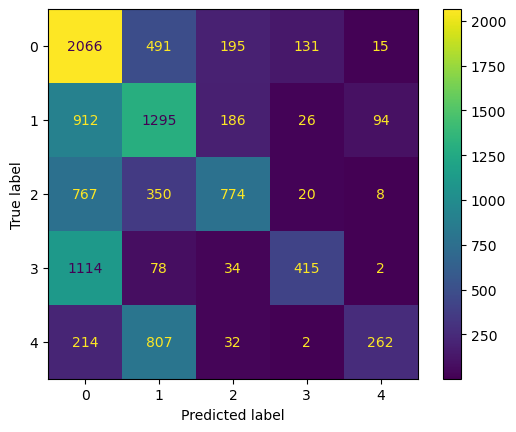

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred = clf.predict(x_test)
matrix2 = confusion_matrix(y_test, pred,labels=clf.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=matrix2,display_labels=clf.classes_)
print("Matrix 2")
disp2.plot()

Matrix1


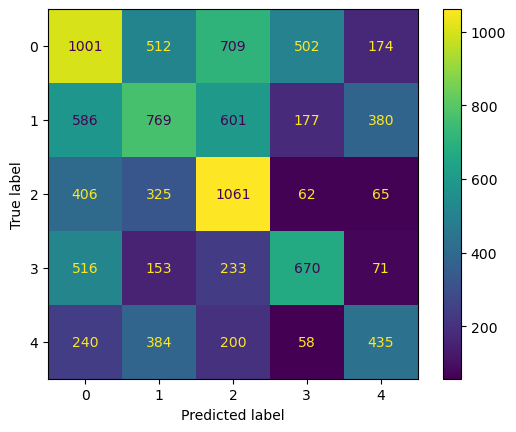

In [27]:
print("Matrix1")
disp1.plot()